# Huffman Coding and Decoding
**Student**: Vinícius Campos Tinoco Ribeiro  
**Registration number**: 20180153460

## Description

The Huffman algorithm is based on intensity frequency, which objetive is decrease the coding size mapping the intensities to binary values, where the most common values are mapped to short binary numbers. For example, suppose an image *3x3* (Figure 1) with following frequency table (Table 1): 
<table style="border: 1px solid black;">
    <tr>
        <td style="background:white;border:1px solid black;"></td>
        <td style="background:white;border:1px solid black;"></td>
        <td style="background:white;border:1px solid black;"></td>
    </tr>
    <tr>
        <td style="background:rgb(127,127,127);border:1px solid black;"></td>
        <td style="background:white;border:1px solid black;"></td>
        <td style="background:white;border:1px solid black;"></td>
    </tr>
    <tr>
        <td style="background:black;border:1px solid black;"></td>
        <td style="background:rgb(127,127,127);border:1px solid black;"></td>
        <td style="background:white;border:1px solid black;"></td>
    </tr>
</table>
<p style="text-align: center;"> Figure 1 - Example </p>

<table style="text-align:center;">
    <tr style="font-weight:bold;">
        <td>Color</td>
        <td>Frequency</td>
    </tr>
    <tr>
        <td>255</td>
        <td>5</td>
    </tr>
    <tr>
        <td>127</td>
        <td>2</td>
    </tr>
    <tr>
        <td>0</td>
        <td>1</td>
    </tr>    
</table>
<p style="text-align: center;"> Table 1 - Frequency table </p>

The representation of Figure 1 in **ppm** format is: 11111111(255) 11111111(255) 11111111(255) 01111111(127) 11111111(255) 11111111(255) 00000000(0) 01111111(127) 11111111(255), which represents at least 72 bits or 9 bytes. Using Huffman algorithm, the code may be reduced to 0 0 0 10 0 0 11 10 0, that contains 12 bits or 1.5 bytes. 

The content bellow presents an implementation in python of Huffman coding and decoding.

In [13]:
# Import libriaries
import cv2
import sys
import operator
import argparse
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### *Node* class definition to create the tree representation:

In [2]:
class Node:
    def __init__(self, data=None, left=None, right=None, p=0):        
        self.data = data
        self.left = left
        self.right = right
        self.p = p

#### Function definition to apply binary search

In [3]:
def lower_bound(x, vector):
    if len(vector) == 0:
        return 0
    l = 0
    r = len(vector) - 1
    while(r - l > 1):
        m = (l+r)//2
        if vector[m].p == x:
            return m
        elif x < vector[m].p:
            r = m
        else:
            l = m
            
    if vector[r].p <= x:
        return r
    if vector[l].p <= x:
        return l
    else:
        return 0

## Encoding section
#### Function definition to generate tree of binary values from intensities array

In [4]:
def generate_tree(intensities):
    
    if len(intensities) == 0:
        return Node()
    
    while len(intensities) > 1:
        left = intensities[1]
        right = intensities[0]
        node = Node(left=left, right=right, p = (left.p + right.p))
        
        intensities = intensities[2:]
        pos = lower_bound(node.p, intensities)
        intensities.insert(pos, node)
    
    return intensities[0]

#### Function definition to produce the configuration of colors 

In [5]:
def inorder(node, code=""):
    output = ""
    colors = {}
    if (node.left == None) and (node.right == None) and (node.data != None):
        output = ("%s %s\n" % (str(node.data), code))
        colors[node.data] = code
        
    if node.left != None:
        o,c = inorder(node.left, code+"0")
        output += o
        colors.update(c)
    if node.right != None:
        o,c = inorder(node.right, code+"1")
        output += o
        colors.update(c)
        
    return output,colors

#### Function definition to obtain some informations about the image 

In [6]:
def pre_processing(img):
    h,w = img.shape[:2]
    c = 1
    if len(img.shape) > 2:
        c = img.shape[2]
    
    code = {}
    code['width'] = w
    code['height'] = h
    code['channels'] = c
    intensities = [(i,0) for i in range(256)]
    
    return code,intensities

#### Function definition to obtain initial information about image, like intensities, width, height and the tree based on intensities.

In [7]:
def huffman(img):
    code,intensities = pre_processing(img)
    
    for row in range(code['height']):
        for col in range(code['width']):
            if code['channels'] > 1:
                for c in range(code['channels']):
                    intensity = img[row,col,c]
                    intensities[intensity] = ( intensity, intensities[intensity][1]+1 )
            else:
                intensity = img[row,col]
                intensities[intensity] = ( intensity, intensities[intensity][1]+1 )
    intensities.sort(key = operator.itemgetter(1), reverse=True)
    max_index = 0
    
    code['intensity_p'] = []
    for (i,j) in intensities:
        if j == 0:
            break
        code['intensity_p'].append( Node(data=i,p=j) )
    
    code['intensity_p'].reverse()
    code['tree'] = generate_tree(code['intensity_p'])
    
    return code

#### The following 2 functions are responsible for encoding a string of zeros and ones (binary values) into the binary format.

In [8]:
def apply_padding(encoded_text):
    extra_padding = 8 - len(encoded_text) % 8
    for i in range(extra_padding):
        encoded_text += "0"
        
    padded_info = "{0:08b}".format(extra_padding)
    encoded_text = padded_info + encoded_text
    return encoded_text

def get_byte_array(padded_encoded_text):
    if(len(padded_encoded_text) % 8 != 0):
        print("Encoded text not padded properly")
        exit(0)

    b = bytearray()
    for i in range(0, len(padded_encoded_text), 8):
        byte = padded_encoded_text[i:i+8]
        b.append(int(byte, 2))
    return b

#### The main function of compression algorithm, which uses all the above functions and produces a file containing the width, height, channels, a flag (name, *vinicius*) and the image(zeros and ones), but in binary format. 

In [9]:
def compress(img, code, filename, output_dir):
    f = open(output_dir + '/' + filename.split('/')[-1].split('.')[0] + '.vh', 'wb')    
    colors_str, colors_map = inorder(code['tree'])
    encoded_text = ""
    for row in tqdm(range(code['height'])):
        for col in range(code['width']):
            if code['channels'] > 1:
                for c in range(code['channels']):
                    encoded_text += colors_map[ img[row,col,c] ]
            else:
                encoded_text += colors_map[ img[row,col] ]
    encoded_text = apply_padding(encoded_text)

    configs  = str(code['width']) + '\n'
    configs += str(code['height']) + '\n'
    configs += str(code['channels']) + '\n'
    configs += colors_str + 'vinicius'
    
    txt_size = len(str(len(configs)))
    configs = str(len(configs) + len(str(len(configs) + txt_size)) + 1) + '\n' + configs

    f = open(output_dir + '/' + filename.split('/')[-1].split('.')[0] + '.vh', 'w')
    f.write(configs)
    f.close()

    b = get_byte_array(encoded_text)
    f = open(output_dir + '/' + filename.split('/')[-1].split('.')[0] + '.vh', 'ab')
    f.write(bytes(b))
    f.close() 

## Decoding section
#### This part is simpler than the section before. The following 3 functions is responsible for applying the decoding operation.

#### This function gets information about the configuration of compressed file.

In [10]:
def get_config(fileconfig):
    code={}
    config={}
    size = 0
    with open(fileconfig, 'rb') as f:
        content = f.read()
        content = str(content)
        size = len(content.split('vinicius')[0][2:])
        lines = content.split('vinicius')[0][2:].split('\\n')
        config['size'] = int(lines[0])
        config['width'] = int(lines[1])
        config['height'] = int(lines[2])
        config['channels'] = int(lines[3])
        for line in lines[4:]:
            color_bin = line.split(' ')
            if len(color_bin) >= 2:
                code[int(color_bin[1],2)] = int(color_bin[0])
    return size, config, code

#### The following function recreates the image using the compressed file informations.

In [11]:
def decode(code, config, map_values):
    image = np.zeros((config['height'],config['width']), dtype='uint8')
    if config['channels'] > 1:
        image = np.zeros((config['height'],config['width'],config['channels']), dtype='uint8')
    index = 0
    last_valid = 0
    length = len(code)
    for row in tqdm(range(config['height'])):
        for col in range(config['width']):
            for c in (range(config['channels'])):
                value = -1
                while(index < length):
                    number = int(''.join(map(str, code[last_valid:index+1] )),2)
                    index += 1
                    if number in map_values:
                        value = map_values[number]
                        last_valid = index
                        break
                if config['channels'] > 1:
                    image[row,col,c] = value
                else:
                    image[row,col] = value
    return image

#### This is the main function of decoding, which receives the compressed file and generates a new figure in a known format.

In [12]:
def decompress(filename, output_dir):
    size, config, map_values = get_config(filename)
    with open(filename, 'rb') as f:
        code = ""
        byte = f.read(config['size'] + 1)
        byte = f.read(1)
        while byte != b"":
            # Do stuff with byte.
            code += bin( ord(byte) )[2:].rjust(8, '0')
            byte = f.read(1)
    code = [int(x) for x in code]
    result = decode(code, config, map_values)
    cv2.imwrite(output_dir + '/' + filename.split('/')[-1].split('.')[0] + '.png', result)

### Example of usage

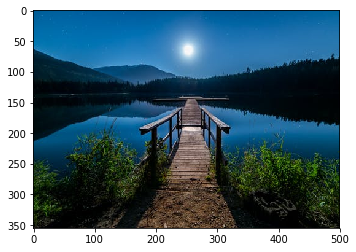

100%|██████████| 355/355 [00:00<00:00, 966.71it/s]


In [16]:
filename = 'images/landscape.ppm'
landscape = cv2.imread(filename)
landscape_bgr = cv2.cvtColor(landscape, cv2.COLOR_BGR2RGB)
plt.imshow(landscape_bgr)
plt.show()

code = huffman(landscape)
compress(landscape, code, filename, 'results/')

100%|██████████| 355/355 [00:09<00:00, 44.72it/s]


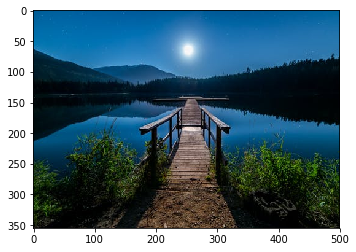

In [17]:
fileconfig = 'results/landscape.vh'
decompress(fileconfig, 'results/images/')

filename_result = 'results/images/landscape.png'
result = cv2.imread(filename_result)
result_bgr = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result_bgr)
plt.show()

#### Size of original and compressed file

In [25]:
print("Original(PPM3):", end='')
!du -h {filename}

print("Original(PPM6):", end='')
!du -h {'images/landscape_compressed.ppm'}

print("Compressed:", end='')
!du -h {fileconfig}

Original(PPM3):1,6M	images/landscape.ppm
Original(PPM6):524K	images/landscape_compressed.ppm
Compressed:496K	results/landscape.vh


## The same code is available on huffman.py file. Follow the instructions on help for discovering the correct params.